Se conecta el colab con google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base = "/content/drive/MyDrive/Colab Notebooks/Trabajo Practico Final"
os.chdir(base)

print("Directorio actual:", os.getcwd())

Directorio actual: /content/drive/MyDrive/Colab Notebooks/Trabajo Practico Final


# **Trabajo Final | Lenguajes 2025 | Alumnos: Saraví Genaro, Ortiz Brandon**

In [ ]:
# Librerías para análisis de datos y gráficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas para rutas de archivos y leer listas en texto
from pathlib import Path
import ast

%matplotlib inline
# Carga de archivos principales del dataset
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

En esta sección se importan las librerías necesarias para el análisis (pandas, numpy y librerías de gráficos) y se cargan los dos archivos CSV del dataset TMDB. Con esto obtenemos las tablas principales (movies y credits) con las que trabajaremos en todo el proyecto.

In [ ]:
# Limpieza básica y columnas nuevas
# Convertir fecha
movies["release_date"] = pd.to_datetime(movies["release_date"], errors="coerce")
movies["year"] = movies["release_date"].dt.year
movies["decade"] = (movies["year"] // 10) * 10

# Reemplazar ceros en budget/revenue
movies["budget"] = movies["budget"].replace(0, np.nan)
movies["revenue"] = movies["revenue"].replace(0, np.nan)

# Calcular ROI
movies["roi"] = movies["revenue"] / movies["budget"]

En esta sección se importan las librerías necesarias para el análisis (pandas, numpy y librerías de gráficos) y se cargan los dos archivos CSV del dataset TMDB. Con esto obtenemos las tablas principales (movies y credits) con las que trabajaremos en todo el proyecto.

In [ ]:
# Convertir el texto de géneros en listas reales de diccionarios
def extraer_generos(genres_str):
    try:
        generos = ast.literal_eval(genres_str)
        return [g["name"] for g in generos] # Extraer solo nombres
    except:
        return []

# Crear columna con lista de géneros y separar cada género en su propia fila
movies["genre_list"] = movies["genres"].apply(extraer_generos)
movies_exploded = movies.explode("genre_list").rename(columns={"genre_list": "genre"})

Aquí se transforma la columna de géneros, que viene como texto, en listas reales, y luego se usa explode para generar una fila por cada género asociado a cada película. Esto permite calcular estadísticas por género (como promedios de ROI) de forma correcta y detallada.

EJE 1 - ROI promedio por género

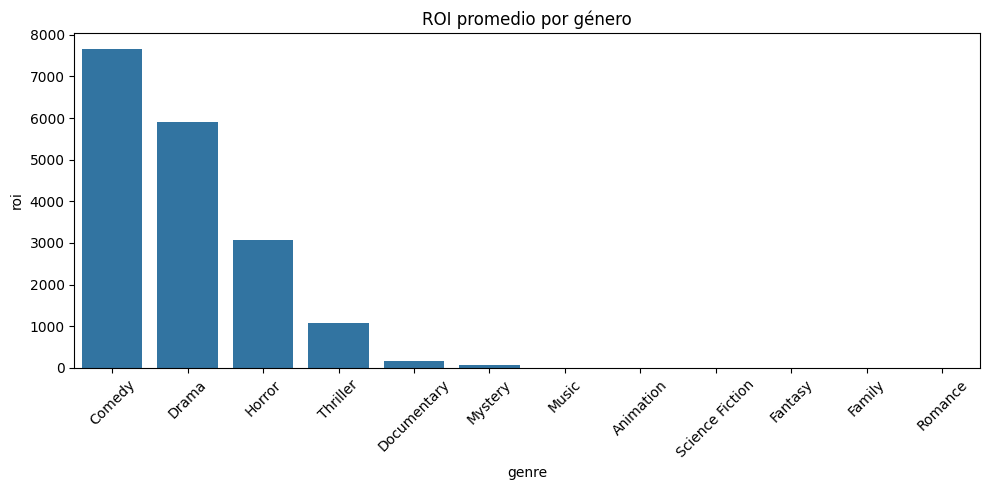

In [ ]:
# Agrupar por género y calcular el ROI promedio
roi_by_genre = (
    movies_exploded
    .dropna(subset=["roi", "genre"])
    .groupby("genre")["roi"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Grafico
plt.figure(figsize=(10,5))
sns.barplot(data=roi_by_genre.head(12), x="genre", y="roi")
plt.xticks(rotation=45)
plt.title("ROI promedio por género")
plt.tight_layout()
plt.show()

Conclusion eje 1: Se calcula el ROI promedio de cada género y se visualiza en un gráfico de barras. Esto permite identificar cuáles géneros resultan más rentables y comparar su desempeño económico relativo dentro del dataset.

EJE 2 – Relación entre presupuesto y rating

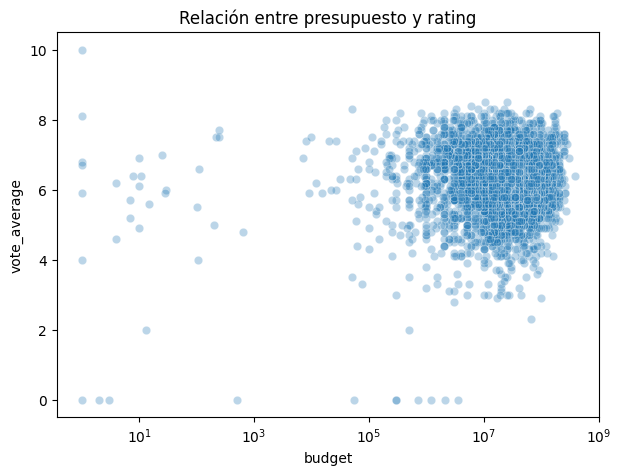

In [ ]:
# Filtrar películas que tengan presupuesto y rating válidos
df = movies.dropna(subset=["budget", "vote_average"])

# Calcular correlaciones entre presupuesto y rating
pearson = df["budget"].corr(df["vote_average"], method="pearson")
spearman = df["budget"].corr(df["vote_average"], method="spearman")

# Grafico dispersograma
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="budget", y="vote_average", alpha=0.3)
plt.xscale("log")
plt.title("Relación entre presupuesto y rating")
plt.show()

Conclusion eje 2: Se analiza si existe relación entre el presupuesto de una película y su rating. Se calculan las correlaciones (Pearson y Spearman) y se grafica un dispersograma. Los resultados permiten evaluar si un mayor presupuesto se asocia con mejores calificaciones del público.

EJE 3 – Evolución de la duracion (runtime) de las peliculas en los últimos 50 años

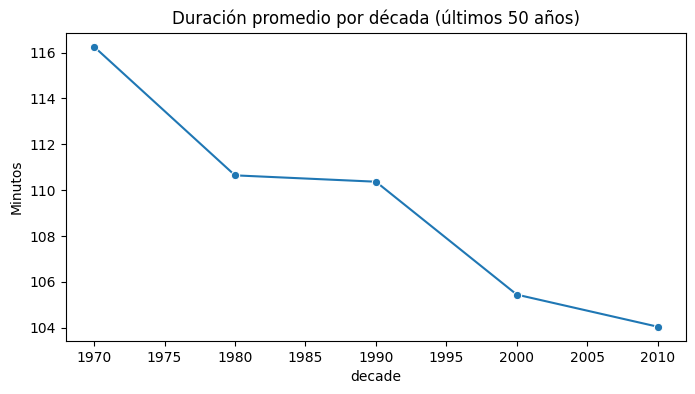

In [ ]:
# Filtrar películas desde 1970 (o desde 50 años atrás)
df_runtime = movies.dropna(subset=["runtime", "decade"])
df_runtime = df_runtime[df_runtime["decade"] >= 1970]

# Calcular promedio por década
runtime_by_decade = (
    df_runtime
    .groupby("decade")["runtime"]
    .mean()
    .reset_index()
)

# Grafico
plt.figure(figsize=(8,4))
sns.lineplot(data=runtime_by_decade, x="decade", y="runtime", marker="o")
plt.title("Duración promedio por década (últimos 50 años)")
plt.ylabel("Minutos")
plt.show()

Conclusion eje 3: Se estudia cómo ha cambiado la duración promedio de las películas a lo largo de las décadas. Tras agrupar por década y calcular el promedio de runtime, se grafica la tendencia, lo que permite observar si las películas se han vuelto más largas o más cortas con el paso del tiempo.

In [ ]:
# Exportación (JSON/CSV) para la mini API
Path("salidas").mkdir(exist_ok=True)

roi_by_genre.to_json("salidas/roi_by_genre.json", orient="records")
runtime_by_decade.to_json("salidas/runtime_by_decade.json", orient="records")
df[["budget","vote_average"]].to_json("salidas/budget_rating.json", orient="records")

print("Archivos exportados en la carpeta 'salidas'.") # Esto no sirve para el notebook pero si para el visual

Archivos exportados en la carpeta 'salidas'.


Mini Api-Local

In [ ]:
# Mini API local (Flask – archivo app.py)
from flask import Flask, jsonify
import pandas as pd

# Crear endpoints que devuelven los datos en formato JSON
app = Flask(__name__)

# Cargar los JSON generados por el análisis
roi = pd.read_json("salidas/roi_by_genre.json")
runtime = pd.read_json("salidas/runtime_by_decade.json")
budget_rating = pd.read_json("salidas/budget_rating.json")

# Endpoints
@app.get("/roi")
def get_roi():
    return jsonify(roi.to_dict(orient="records"))

@app.get("/runtime")
def get_runtime():
    return jsonify(runtime.to_dict(orient="records"))

@app.get("/budget_rating")
def get_budget_rating():
    return jsonify(budget_rating.to_dict(orient="records"))

# Levantar la API local
if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


En este bloque se construye una mini API local con Flask que carga los archivos JSON generados en el análisis y los expone mediante endpoints (/roi, /runtime, /budget_rating). Esto permite acceder a los resultados del trabajo desde el navegador o herramientas externas de forma simple y organizada.